# 人流量计数+足迹追踪

多目标追踪

## 进入 MMTracking 主目录

In [1]:
import os
os.chdir('mmtracking')
os.listdir()

['.git',
 '.circleci',
 '.dev_scripts',
 '.github',
 '.gitignore',
 '.pre-commit-config.yaml',
 '.readthedocs.yml',
 'CITATION.cff',
 'LICENSE',
 'MANIFEST.in',
 'README.md',
 'README_zh-CN.md',
 'configs',
 'demo',
 'docker',
 'docs',
 'mmtrack',
 'model-index.yml',
 'requirements.txt',
 'requirements',
 'resources',
 'setup.cfg',
 'setup.py',
 'tests',
 'tools',
 'mmtrack.egg-info',
 'checkpoints',
 'outputs',
 'data',
 'test']

## 导入工具包

In [2]:
# 导入 opencv-python
import cv2

import mmcv

import numpy as np

import random

import seaborn as sns

# 导入可视化工具包 matplotlib，并让绘制的图像嵌入在 notebook 中
import matplotlib.pyplot as plt
%matplotlib inline

import mmcv
import tempfile
from mmtrack.apis import inference_mot, init_model
from mmtrack.core import imshow_tracks, results2outs
    
# 定义可视化图像函数，输入图像 array，可视化图像
def show_img_from_array(img):
    '''输入 array，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来'''
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()

def get_color(seed):
    '''
    传入追踪ID，生成专属颜色
    '''
    random.seed(seed)
    # 从调色板中随机挑选一种颜色
    bbox_color = random.choice(palette)
    bbox_color = [int(255 * c) for c in bbox_color][::-1]
    return bbox_color

In [3]:
from mmtrack.core import imshow_tracks, results2outs

# 目标检测框线宽
thickness = 2

# 轨迹线粗细
trace_radius = 10

# 目标检测置信度阈值
score_thr = 0.0

# 字体大小
font_scale = 0.4
 
# 置信度和 ID 单个数字的宽高
text_width = 9
text_height = 13

# 类别信息
classes = None

# 生成调色板
palette = sns.color_palette('hls',30)

# 目标检测框线宽
thickness = 2

# 轨迹线粗细
trace_radius = 10

# 目标检测置信度阈值
score_thr=0.0

# 字体大小
font_scale=0.4

# 置信度和 ID 单个数字的宽高
text_width = 9
text_height = 13

# 类别信息
classes = None

In [4]:
def get_color(seed):
    random.seed(seed)
    # 从调色板中随机挑选一种颜色
    bbox_color = random.choice(palette)
    bbox_color = [int(255 * c) for c in bbox_color][::-1]
    return bbox_color

def process_result(result):
    '''处理单帧函数，输入MOT多目标追踪结果，输出 MOT多目标追踪可视化图像、所有目标轨迹中心点坐标'''

    #######################
    # 整理多目标追踪结果
    #######################
    # 进一步整理result结果
    outs_track = results2outs(bbox_results=result.get('track_bboxes', None))

    # 取出结果
    bboxes = outs_track.get('bboxes', None)
    labels = outs_track.get('labels', None)
    ids = outs_track.get('ids', None)

    # 目标检测框的 x坐标 不超过图像宽度
    bboxes[:, [0,2]] = np.clip(bboxes[:, [0,2]], 0, img.shape[1])
    # 目标检测框的 y坐标 不超过图像高度
    bboxes[:, [1,3]] = np.clip(bboxes[:, [1,3]], 0, img.shape[0])

    # 筛选出目标检测置信度大于指定阈值的目标，并取出其索引、目标检测、类别、ID信息
    inds = np.where(bboxes[:, -1] > score_thr)[0]
    bboxes = bboxes[inds]
    labels = labels[inds]
    ids = ids[inds]

    #######################
    # 遍历每个目标，可视化
    #######################
    trace_coords_frame = [] # 存放当前帧画面中 所有目标轨迹中心点坐标
    for i, (bbox, label, id) in enumerate(zip(bboxes, labels, ids)):
        # 获取目标检测框的左上角、右下角坐标，及置信度
        x1, y1, x2, y2 = bbox[:4].astype(np.int32)
        score = float(bbox[-1])

        # 绘制目标检测矩形框
        bbox_color = get_color(id)
        cv2.rectangle(img, (x1, y1), (x2, y2), bbox_color, thickness=thickness)

        # 绘制矩形框中心点轨迹点，指定圆心坐标和半径，红色，最后一个参数为线宽，-1表示填充
        # trace_coord = {id:[[(x1+x2)//2, (y1+y2)//2], bbox_color]}
        # trace_coord_obj = [id, [(x1+x2)//2, (y1+y2)//2, bbox_color]] # 目标检测框中心点作为轨迹点
        trace_coord_obj = [id, [(x1+x2)//2, y2, bbox_color]]           # 目标检测框底边中点作为轨迹点
        trace_coords_frame.append(trace_coord_obj)
        
        # 置信度文字
        text = '{:.02f}'.format(score)
        if classes is not None: # 类别信息
            text += f'|{classes[label]}'
        # 绘制置信度文字的背景
        width = len(text) * text_width
        img[y1:y1 + text_height, x1:x1 + width, :] = bbox_color
        # 写置信度文字：图像，文字，左上角坐标，字体，字体大小，颜色，字体粗细
        cv2.putText(img, text, (x1, y1 + text_height - 2), cv2.FONT_HERSHEY_COMPLEX, font_scale, color=(0, 0, 0))

        # ID
        text = str(id)
        # 绘制ID文字的背景
        width = len(text) * text_width
        img[y1 + text_height:y1 + 2 * text_height, x1:x1 + width, :] = bbox_color
        # 写 ID文字：图像，文字，左上角坐标，字体，字体大小，颜色，字体粗细
        cv2.putText(img, str(id), (x1, y1 + 2 * text_height - 2), cv2.FONT_HERSHEY_COMPLEX, font_scale, color=(0, 0, 0))

    return img, trace_coords_frame

In [5]:
os.mkdir('test')

FileExistsError: [Errno 17] File exists: 'test'

In [ ]:
# 输入输出视频路径
input_video = 'data/mot_people_long.mp4'
output = 'outputs/output_H1_MOT_people_long.mp4'

## ByteTrack算法
# 指定 config 配置文件 和 模型权重文件，创建模型
mot_config = './configs/mot/bytetrack/bytetrack_yolox_x_crowdhuman_mot17-private-half.py'
mot_checkpoint = 'https://download.openmmlab.com/mmtracking/mot/bytetrack/bytetrack_yolox_x/bytetrack_yolox_x_crowdhuman_mot17-private-half_20211218_205500-1985c9f0.pth'
# 初始化模型
mot_model = init_model(mot_config, mot_checkpoint, device='cuda:0')

## Deepsort算法
# # 指定 config 配置文件 和 模型权重文件，创建模型
# mot_config = './configs/mot/deepsort/deepsort_faster-rcnn_fpn_4e_mot17-private-half.py'
# # 初始化模型
# mot_model = init_model(mot_config, device='cuda:0')

# 读入待预测视频
imgs = mmcv.VideoReader(input_video)

prog_bar = mmcv.ProgressBar(len(imgs))
out_dir = tempfile.TemporaryDirectory()
out_path = 'test'

# 人数计数
num = 0
# 记录每一帧的人数计数
num_per_frame = []

# 记录每一帧的各目标轨迹点坐标
trace_coord_video = []

# 对视频逐帧处理
for frame_id, img in enumerate(imgs):
    
    #######################
    # 运行多目标追踪
    #######################
    result = inference_mot(mot_model, img, frame_id=frame_id)
    
    # 获取当前帧目标检测可视化效果，及各目标轨迹点坐标
    img, trace_coord_frame = process_result(result)
    trace_coord_video.append(trace_coord_frame)
    
    #######################
    # 绘制轨迹点：从第一帧到当前帧 所有目标的轨迹点
    #######################
    for trace_coord_frame in trace_coord_video: # 遍历每一帧
        for trace_coord_obj in trace_coord_frame: # 遍历每一个目标
            # 绘制圆，指定圆心坐标和半径，颜色，最后一个参数为线宽，-1表示填充
            cv2.circle(img, (trace_coord_obj[1][0], trace_coord_obj[1][1]),5, trace_coord_obj[1][2], -1)
    
    #######################
    #  获取人数
    #######################
    # 用当前最大的 ID 号作为人数值
    if result['track_bboxes'][0][:,0].any(): # 检测出行人
        num = max(num, 1+max(result['track_bboxes'][0][:,0]))
    else: # 没有检测出行人
        num = num
    num_per_frame.append([frame_id, num])
    # 可视化总人数：图片，添加的文字，左上角坐标，字体，字体大小，颜色，字体粗细
    img = cv2.putText(img, str(int(num)), (25, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 2)

    # 将处理后的该帧画面图像文件，保存至 /tmp 目录下
    cv2.imwrite(f'{out_path}/{frame_id:06d}.jpg', img)
    
    # 更新进度条
    prog_bar.update()

# 由每一帧的图像文件，生成视频
mmcv.frames2video(out_path, output, fps=imgs.fps, fourcc='mp4v')
out_dir.cleanup()

print('帧图像保存路径',out_path)
print('总人数', int(num))

2022-04-19 23:08:22,839 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2022-04-19 23:08:22,877 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2022-04-19 23:08:22,879 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2022-04-19 23:08:22,881 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2022-04-19 23:08:23,385 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 320, 1, 

load checkpoint from http path: https://download.openmmlab.com/mmtracking/mot/bytetrack/bytetrack_yolox_x/bytetrack_yolox_x_crowdhuman_mot17-private-half_20211218_205500-1985c9f0.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector

## 绘制人流量折线图

In [ ]:
num_per_frame[:10]

In [ ]:
X_frames = np.array(num_per_frame)[:,0]

In [ ]:
Y_people = np.array(num_per_frame)[:,1]

In [ ]:
X_frames.max()

In [ ]:
plt.plot(np.array(num_per_frame)[:,0], np.array(num_per_frame)[:,1])
plt.show()

In [16]:
os.mkdir('test2')

### 绘制折线图叠加视频图

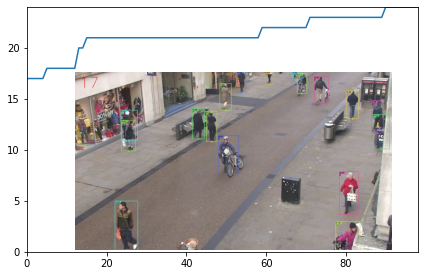

In [25]:
os.chdir('test')

each = os.listdir()[0]

# 折线图宽高
plt.rcParams["figure.figsize"] = [7, 4.50]
# plt.rcParams["figure.autolayout"] = True
# 导入图片
im = plt.imread(each) # insert local path of the image.
# fig, ax = plt.subplots()
fig, ax = plt.subplots()
plt.ylim(0, int(num))
plt.xlim(0, int(X_frames.max()))
plt.plot(X_frames[:frame_id+1], Y_people[:frame_id+1])

# 绘制图片，在图中的坐标与图片宽高，层叠次序
# img_ax = fig.add_axes([0.42,0.03,0.55,0.55], anchor='NW', zorder=0)
fig.add_axes([0.22,0.13,0.65,0.55], anchor='NW', zorder=0)
# img_ax.imshow(im)
plt.imshow(im)
# img_ax.axis('off')
plt.axis('off')
plt.show()

os.chdir('../')

### 逐帧绘制折线图叠加视频图

In [ ]:
os.chdir('test')

for frame_id, each in enumerate(os.listdir()):
    try:
        # 折线图宽高
        plt.rcParams["figure.figsize"] = [7, 4.50]
        # plt.rcParams["figure.autolayout"] = True

        # 导入图片
        im = plt.imread(each) # insert local path of the image.
        fig, ax = plt.subplots()
        plt.ylim(0, int(num))
        plt.xlim(0, int(X_frames.max()))
        plt.plot(X_frames[:frame_id+1], Y_people[:frame_id+1])

        # 绘制图片，在图中的坐标与图片宽高，层叠次序
        img_ax = fig.add_axes([0.32,0.13,0.55,0.55], anchor='NW', zorder=0)
        img_ax.imshow(im)
        img_ax.axis('off')
        # plt.show()
        fig.savefig(f'../test2/{frame_id:06d}.jpg')
    except:
        pass

os.chdir('../')

# 由每一帧的图像文件，生成视频
mmcv.frames2video('test2', 'outputs/output_H2_count_plot.mp4', fps=imgs.fps, fourcc='mp4v')